In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tnrange
from sklearn.svm import SVC

In [3]:
from telepyth import TelepythClient
tp = TelepythClient()
from experiment import get_dataset, mean_confidence_interval

Use token from .telepythrc.


In [4]:
from kernels import approximate_arccos0_kernel, approximate_arccos1_kernel, \
                    approximate_rbf_kernel, arccos0_kernel, arccos1_kernel
from rom import generate_rademacher_weights, generate_gort_weights
from utils import generate_random_weights, generate_householder_weights, \
                    generate_butterfly_weights, radius, butterfly_params, \
                    generate_halton_weights
from mapping import fast_batch_approx_rbf, fast_batch_approx_arccos1, \
                fast_batch_approx_arccos0
from sklearn.metrics.pairwise import rbf_kernel
from gaussquad import generate_gq_weights, explicit_map, rbf_kernel_via_explicit_map

In [5]:
import ctypes
mkl_rt = ctypes.CDLL('libmkl_rt.so')
print(mkl_rt.mkl_get_max_threads())
mkl_get_max_threads = mkl_rt.mkl_get_max_threads
def mkl_set_num_threads(cores):
    mkl_rt.mkl_set_num_threads(ctypes.byref(ctypes.c_int(cores)))

mkl_set_num_threads(16)
print(mkl_get_max_threads())

16
16


# USPS

In [6]:
dataset_name = 'USPS'
dataset, d = get_dataset(dataset_name, 4500)
xtrain, ytrain, xtest, ytest = dataset
n1 = xtrain.shape[0]
n2 = xtest.shape[0]

## Classification accuracy

In [37]:
clf_rbf = SVC(gamma=0.026256662181703513)
clf_rbf.fit(xtrain, ytrain)
exact_rbf = clf_rbf.score(xtest, ytest)

In [38]:
exact_rbf

0.97831138652207594

In [123]:
def get_scores(dataset, approx_type, estimator, K, runs, shift):
    xtrain, ytrain, xtest, ytest = dataset
    n = xtrain.shape[1]
    n1 = xtrain.shape[0]
    n2 = xtest.shape[0]
    
    rbf_scores = np.empty((K, runs))

    if approx_type == 'B simplex':
        stacked_train = np.asfortranarray(np.vstack([xtrain, xtrain])).T
        stacked_test = np.asfortranarray(np.vstack([xtest, xtrain])).T
        
    for k in tnrange(K):
        for j in tnrange(runs):
            t = 2 * (k+shift)
            L = 2 * (k+shift) * (n+1)
            r = radius(n, t)
            b_params = butterfly_params(n, t)
            if approx_type == 'B simplex':
                gs = [0.01768333768771959, 0.015744080979183603, 0.014854012292683887,
                      0.01575336267737855, 0.016889841804635597]
                g = gs[shift-1]
                #0.01575336267737855
                #0.014854012292683887
                #0.015744080979183603
                #0.01768333768771959
                K_train = fast_batch_approx_rbf(stacked_train, n1, k+shift, r, b_params, gamma=g)
                K_test = fast_batch_approx_rbf(stacked_test, n2, k+shift, r, b_params, gamma=g)
            
            elif approx_type == 'GQ':
                gs = [0.012387649512187007, 0.01477360058835469, 0.018198266788848193, 
                      0.019153754863224758, 0.021336551593122498]
                g = gs[shift-1]
                #0.021336551593122498
                #0.019153754863224758
                #0.018198266788848193
                #0.01477360058835469
                #0.012387649512187007
                W, A = generate_gq_weights(n, L, 2)
                Te, Tr = explicit_map(xtest, xtrain, W, gamma=g)
                K_train = rbf_kernel_via_explicit_map(Tr, Tr, A)
                K_test = rbf_kernel_via_explicit_map(Te, Tr, A)
            else:
                if approx_type == 'random':
                    M, w = generate_random_weights(k+shift, n)
                    gs = [0.014894775580336816, 0.01723086781622441, 0.013835765950516063, 
                          0.014918642207481032, 0.016133456641192683]
                    g = gs[shift-1]
                    #0.016133456641192683
                    #0.014918642207481032
                    #0.013835765950516063
                    #0.01723086781622441
                    #0.014894775580336816
                elif approx_type == 'ROM':
                    M, w = generate_rademacher_weights(k+shift, n)
                    gs = [0.014139337292059427, 0.016543276680205946, 0.01701149858156894, 
                          0.014952492320430976, 0.015255950998579664]
                    g = gs[shift-1]
                    #0.015255950998579664
                    #0.014952492320430976
                    #0.01701149858156894
                    #0.016543276680205946
                    #0.014139337292059427
                elif approx_type == 'gort':
                    M, w = generate_random_weights(k+shift, n)
                    gs = [0.013391245458595536, 0.012309971668405025, 0.01440796075125589, 
                          0.01654415111309599, 0.016786563544102396]
                    g = gs[shift-1]
                    #0.016786563544102396
                    #0.01654415111309599
                    #0.01440796075125589
                    #0.012309971668405025
                    #0.013391245458595536
                elif approx_type == 'dense B':
                    M, w = generate_butterfly_weights(k+shift, n)
                    gamma = 0.01
                elif approx_type == 'halton':
                    M, w = generate_halton_weights(k+shift, n)
                    gamma = 0.01
                else:
                    raise Exception('no approx type specified')

                K_train = approximate_rbf_kernel(xtrain, xtrain, M, w, gamma=gamma)
                K_test = approximate_rbf_kernel(xtest, xtrain, M, w, gamma=gamma)
    
    
            clf_rbf_pre = estimator(kernel='precomputed')
            clf_rbf_pre.fit(K_train, ytrain)
            rbf_scores[k][j] = clf_rbf_pre.score(K_test, ytest)

    return rbf_scores

In [124]:
K = 1
runs = 30

In [81]:
%%time
%%telepyth
gq_rbf_scores5 = get_scores(dataset, 'GQ', SVC, K, runs)

A Jupyter Widget

A Jupyter Widget


CPU times: user 1min 37s, sys: 8.43 s, total: 1min 46s
Wall time: 1min 1s


In [125]:
%%time
%%telepyth
B_rbf_scores5 = get_scores(dataset, 'B simplex', SVC, K, runs, 5)

A Jupyter Widget

A Jupyter Widget


CPU times: user 7min 47s, sys: 33.6 s, total: 8min 21s
Wall time: 6min 8s


In [85]:
%%time
%%telepyth
g_rbf_scores5 = get_scores(dataset, 'random', SVC, K, runs)

A Jupyter Widget

A Jupyter Widget


CPU times: user 2min 2s, sys: 12 s, total: 2min 14s
Wall time: 1min 22s


In [91]:
%%time
%%telepyth
rom_rbf_scores5 = get_scores(dataset, 'ROM', SVC, K, runs)

A Jupyter Widget

A Jupyter Widget


CPU times: user 2min 1s, sys: 12.1 s, total: 2min 13s
Wall time: 1min 21s


In [93]:
%%time
%%telepyth
gort_rbf_scores5 = get_scores(dataset, 'gort', SVC, K, runs)

A Jupyter Widget

A Jupyter Widget


CPU times: user 2min 3s, sys: 12.5 s, total: 2min 16s
Wall time: 1min 23s


In [109]:
K = 4

gq_rbf_scoresc = np.empty((K, runs))
gq_rbf_scoresc[0,:] = gq_rbf_scores1
gq_rbf_scoresc[1,:] = gq_rbf_scores2
gq_rbf_scoresc[2,:] = gq_rbf_scores3
gq_rbf_scoresc[3,:] = gq_rbf_scores4
# gq_rbf_scoresc[4,:] = gq_rbf_scores5

In [110]:
g_rbf_scoresc = np.empty((K, runs))
g_rbf_scoresc[0,:] = g_rbf_scores1
g_rbf_scoresc[1,:] = g_rbf_scores2
g_rbf_scoresc[2,:] = g_rbf_scores3
g_rbf_scoresc[3,:] = g_rbf_scores4
# g_rbf_scoresc[4,:] = g_rbf_scores5

In [111]:
B_rbf_scoresc = np.empty((K, runs))
B_rbf_scoresc[0,:] = B_rbf_scores1
B_rbf_scoresc[1,:] = B_rbf_scores2
B_rbf_scoresc[2,:] = B_rbf_scores3
B_rbf_scoresc[3,:] = B_rbf_scores4
# B_rbf_scoresc[4,:] = B_rbf_scores5

In [112]:
rom_rbf_scoresc = np.empty((K, runs))
rom_rbf_scoresc[0,:] = rom_rbf_scores1
rom_rbf_scoresc[1,:] = rom_rbf_scores2
rom_rbf_scoresc[2,:] = rom_rbf_scores3
rom_rbf_scoresc[3,:] = rom_rbf_scores4
# rom_rbf_scoresc[4,:] = rom_rbf_scores5

In [113]:
gort_rbf_scoresc = np.empty((K, runs))
gort_rbf_scoresc[0,:] = gort_rbf_scores1
gort_rbf_scoresc[1,:] = gort_rbf_scores2
gort_rbf_scoresc[2,:] = gort_rbf_scores3
gort_rbf_scoresc[3,:] = gort_rbf_scores4
# gort_rbf_scoresc[4,:] = gort_rbf_scores5

ValueError: x and y must have same first dimension, but have shapes (1,) and (4,)

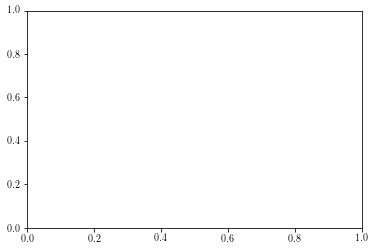

In [122]:
types = ['B', 'GQ']#, 'G', 'ROM', 'Gort']
rbf_scores = [B_rbf_scoresc, gq_rbf_scoresc]#, g_rbf_scoresc, rom_rbf_scoresc, gort_rbf_scoresc]
plot_(rbf_scores, types, 'rbf', dataset_name, exact_rbf)

In [119]:
K

1

In [120]:
def plot_(scores_, labels, kernel_type, dataset_name, exact):
    fig = plt.figure()
    ax = fig.add_subplot('111')
    
    for i,scores in enumerate(scores_):
        x = 2 * (np.arange(1, K+1, 1) + 1) * (d+1)
        ci = np.empty((scores.shape[0], 2))
        mean = np.zeros(scores.shape[0])
        for j in range(scores.shape[0]):
            mean[j], ci[j,0], ci[j,1] = mean_confidence_interval(scores[j,:])
        ax.plot(x, mean, '.-', label=labels[i])
        ax.fill_between(x, np.maximum(0, ci[:, 0]), ci[:, 1], alpha = 0.3)
        
    ax.axhline(exact, linestyle='--', label='exact', color='black')
           
    ax.set_xlabel(r'nfeatures', fontsize=16)
    ax.set_ylabel(r'accuracy', fontsize=16)
    title = f'SVC accuracy using {kernel_type} kernel approximation, {dataset_name}'
    fig.suptitle(title, fontsize=16)
    ax.legend(loc='best', framealpha=0.1)
    plt.tight_layout(pad=3)
    plt.savefig('figure_data/GQaccuracy%s%s.pdf' % (dataset_name, kernel_type), dpi=1200, format='pdf')
    

ValueError: x and y must have same first dimension, but have shapes (1,) and (5,)

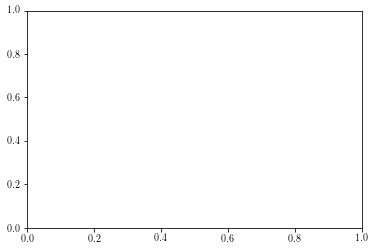

In [121]:
types = ['B', 'GQ', 'G', 'ROM', 'Gort']
rbf_scores = [B_rbf_scores, gq_rbf_scores, g_rbf_scores, rom_rbf_scores, gort_rbf_scores]
plot_(rbf_scores, types, 'rbf', dataset_name, exact_rbf)

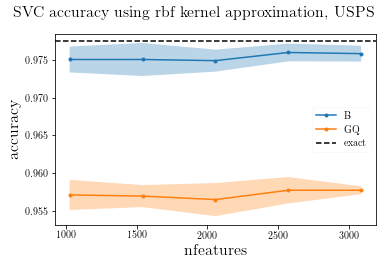

In [29]:
types = ['B', 'GQ']#, 'ROM', 'Gort']
rbf_scores = [B_rbf_scores, gq_rbf_scores]#, rom_rbf_scores, gort_rbf_scores]
plot_(rbf_scores, types, 'rbf', dataset_name, exact_rbf)

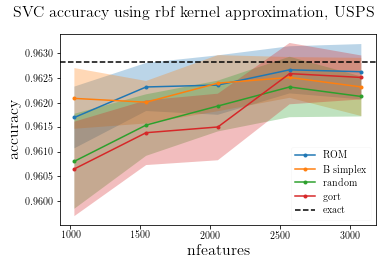

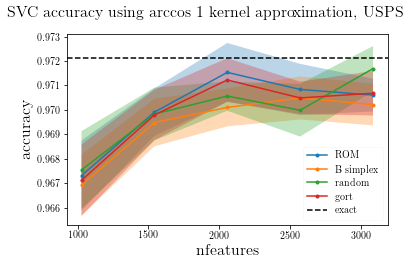

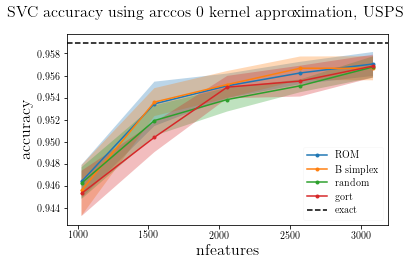

In [15]:
types = [ 'B simplex', 'random', 'gort']

rbf_scores = [rom_rbf_scores, B_rbf_scores, g_rbf_scores, gort_rbf_scores]
arccos_scores = [rom_arccos_scores, B_arccos_scores, g_arccos_scores, gort_arccos_scores]
arccos0_scores = [rom_arccos0_scores, B_arccos0_scores, g_arccos0_scores, gort_arccos0_scores]
plot_(rbf_scores, 
      types, 'rbf', dataset_name, exact_rbf)
plot_(arccos_scores, 
      types, 'arccos 1', dataset_name, exact_arccos1)
plot_(arccos0_scores, 
      types, 'arccos 0', dataset_name, exact_arccos0)

In [16]:
scores_dic = {'RBF': {t:s for t, s in zip(types, rbf_scores)},
              'Arc-cosine 0': {t:s for t, s in zip(types, arccos0_scores)},
              'Arc-cosine 1': {t:s for t, s in zip(types, arccos_scores)}}

In [17]:
np.savez(f'figure_data/acc/accuracy{dataset_name}', scores_dic)

In [18]:
exact = [exact_rbf, exact_arccos0, exact_arccos1]
np.save(f'figure_data/acc/exact{dataset_name}', np.array(exact))

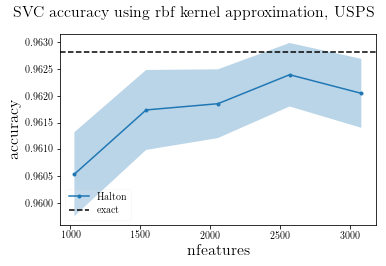

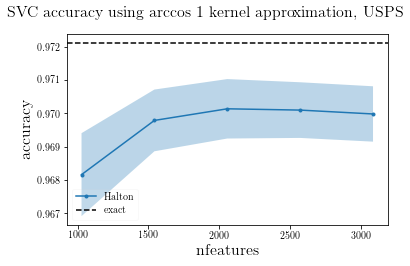

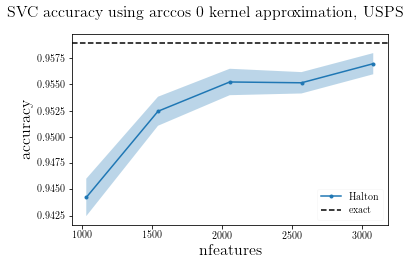

In [19]:
types = ['Halton']
rbf_scores = [halton_rbf_scores]
arccos0_scores = [halton_arccos0_scores]
arccos1_scores = [halton_arccos_scores]
plot_(rbf_scores, 
      types, 'rbf', dataset_name, exact_rbf)
plot_(arccos1_scores, 
      types, 'arccos 1', dataset_name, exact_arccos1)
plot_(arccos0_scores, 
      types, 'arccos 0', dataset_name, exact_arccos0)

scores_dic = {'RBF': {t:s for t, s in zip(types, rbf_scores)},
              'Arc-cosine 0': {t:s for t, s in zip(types, arccos0_scores)},
              'Arc-cosine 1': {t:s for t, s in zip(types, arccos1_scores)}}

np.savez(f'figure_data/acc/haltonaccuracy{dataset_name}', scores_dic)